In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from sparsecoding import inference
from sparsecoding import models
from sparsecoding.data.datasets import field
from sparsecoding.visualization import plot_dictionary
from sparsecoding.visualization import plot_patches

### Define constants and load data

In [2]:
# Enter path of the Field dataset. If it does not exist, it will be downloaded.
data_path = "./"
n_samples = 100
patch_size = 16
n_features = patch_size**2
images = field.FieldDataset(patch_size=patch_size, root=data_path)

# Get n_samples, reshape to 2D, and cast to torch.float32.
data = images[:n_samples].reshape(n_samples, -1).to(torch.float32)
print(data.shape)

torch.Size([100, 256])


### Visualize patches

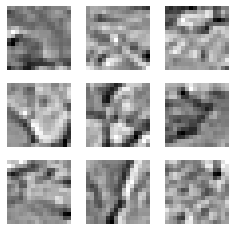

In [3]:
figure = plt.figure(figsize=(4,4))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img = (data[sample_idx])
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze().reshape([patch_size,patch_size]), cmap="gray")
plt.show()

### Sparse Coding via Dictionary Learning

In [4]:
### DEFINE MODEL
ista = inference.ISTA(n_iter=100, sparsity_penalty=2e-1, stop_early=True)
sc = models.SparseCoding(inference_method=ista,n_basis=n_features,n_features=n_features,dictionary_lr=1e-1)

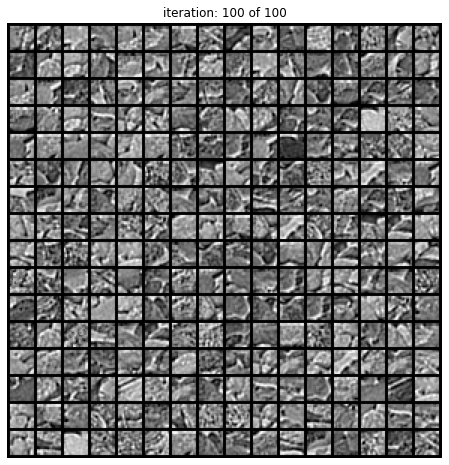

In [5]:
n_epoch = 100
montage_update_rate = 10
nrow = patch_size
fig,ax = plot_dictionary(sc.dictionary,nrow=nrow)
losses = np.array([])

# Learn dictionary (note learn_dictionary() includes inference).
for i in range(n_epoch//montage_update_rate):
    loss = sc.learn_dictionary(dataset=data,n_epoch=n_epoch,batch_size=500)
    losses = np.concatenate([losses,loss])

fig,ax = plot_dictionary(sc.dictionary,fig=fig,ax=ax,title='iteration: %d of %d'%(n_epoch,n_epoch),nrow=nrow)

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:title={'center':'data (100 of 100)'}>)

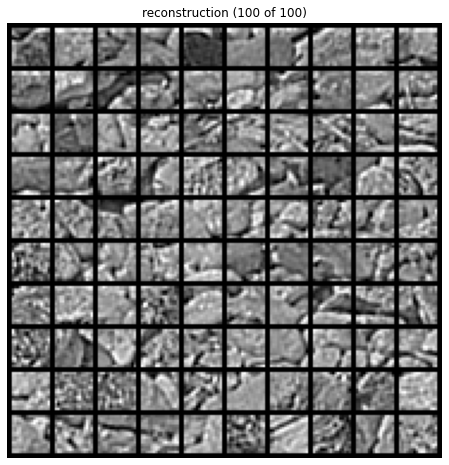

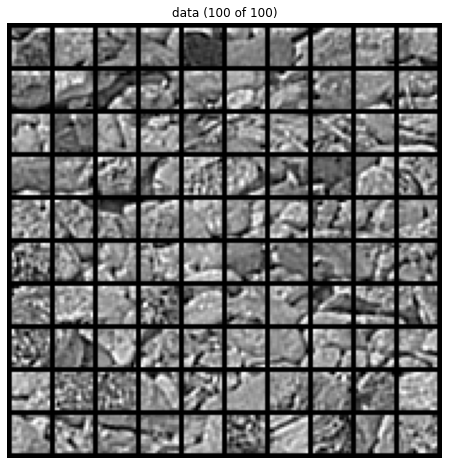

In [6]:
dictionary = torch.tensor(sc.get_numpy_dictionary().astype(np.float32))
a = ista.infer(data, dictionary)
ihat = torch.mm(dictionary, a.T).T
plot_patches(ihat[:100,:], title="reconstruction (100 of {})".format(data.shape[0]))
plot_patches(data[:100,:], title="data (100 of {})".format(data.shape[0]))

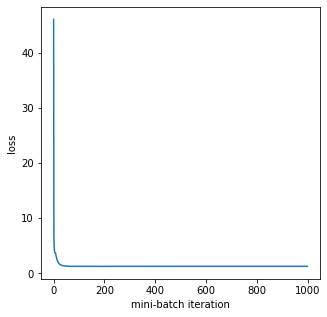

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(losses)
ax.set_xlabel('mini-batch iteration')
ax.set_ylabel('loss')
plt.show()

sparsity (total # of 0s/total # coefficients): 0.9897265625


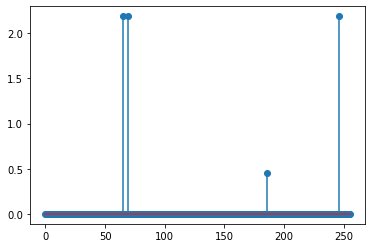

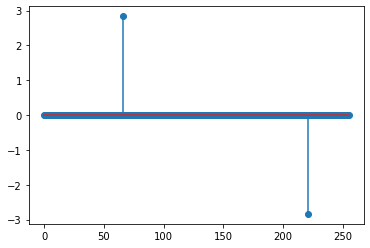

In [8]:
sparsity = np.sum(np.array(a) == 0 * 1)/np.array(a).size
print("sparsity (total # of 0s/total # coefficients): {}".format(sparsity))

plt.stem(a[1])
plt.show()

plt.stem(a[5])
plt.show()